# 0. Imports

In [30]:
from functools import partial
import os
from pathlib import Path

from IPython.display import HTML
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.scipy import stats
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import optax

from demos.showdown.classification import (
    classification_train as benchmark,
    hparam_tune_clf as hpt
)
from rebayes.datasets import classification_data as data_utils

In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
dataset = data_utils.load_mnist_dataset(fashion=False) # load data

2023-05-24 23:51:59.787708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-05-24 23:51:59.787745: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [39]:
# Select 9 random images (different digits) from the test set
X_test, y_test = dataset['test']
# Select 9 different digits from test set
test_images = X_test[jnp.array([jnp.where(y_test == i)[0][0] for i in range(10)])]

# Introduce a randomly permuted image as an OOD sample
ood_img = jr.choice(jr.PRNGKey(0), test_images)
ood_img = jr.permutation(jr.PRNGKey(0), ood_img.ravel()).reshape(ood_img.shape)

For this demo, we don't rescale the parameters.

# 1. MLP Comparison

## 1.1 LeCun-Normal Probe

In [65]:
# Initialize model
mlp_init_fn = lambda key: benchmark.init_model(type='mlp', features=(100, 100, 10), 
                                               key=key, rescale=False, zero_ll=False)
model_dict_mlp = mlp_init_fn(0)

In [66]:
# Tune hyperparameters
X_train, y_train = dataset['train']
train = (X_train[:500], y_train[:500])

kwargs = {
    'memory_size': 5,
    'inflation': "hybrid",
    'lofi_method': "diagonal",
}

pbounds={
    'log_init_cov': (-10.0, 0.0),
    'log_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-90, -90),
    'log_alpha': (-40, -40),
}
agent_type = 'lofi'
init_points, n_iter = 10, 15

ll_callback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_ll)

optimizer = hpt.create_optimizer(
    mlp_init_fn, pbounds, train, dataset['val'], callback=ll_callback, 
    method=agent_type, verbose=2, callback_at_end=False, n_seeds=3, **kwargs
)

optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
)
best_hparams = hpt.get_best_params(optimizer, method=agent_type)
print(f"Best target: {optimizer.max['target']}")

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.634    | -40.0     | -90.0     | -90.0     | -4.551    |
| 2         | -1.675    | -40.0     | -90.0     | -90.0     | -1.082    |
| 3         | -1.713    | -40.0     | -90.0     | -90.0     | -4.711    |
| 4         | -2.325    | -40.0     | -90.0     | -90.0     | -9.129    |
| 5         | -1.573    | -40.0     | -90.0     | -90.0     | -1.3      |
| 6         | -1.255    | -40.0     | -90.0     | -90.0     | -2.195    |
| 7         | -2.27     | -40.0     | -90.0     | -90.0     | -0.5533   |
| 8         | -1.22     | -40.0     | -90.0     | -90.0     | -2.258    |
| 9         | -1.324    | -40.0     | -90.0     | -90.0     | -3.824    |
| 10        | -1.194    | -40.0     | -90.0     | -90.0     | -3.182    |
| 11        | -2.265    | -40.0     | -90.0     | -90.0     | -6.812    |
| 12        | -1.183    | -40.0     | 

In [67]:
# Initialize an instance of the model with best hparams
estimator_mlp, init_mean_mlp, init_cov_mlp = hpt.build_estimator(
    model_dict_mlp,
    best_hparams,
    method=agent_type,
    **kwargs,
)

In [68]:
# Train
def map_callback(bel, *args, **kwargs):
    return bel

_, outcomes = estimator_mlp.scan(init_mean_mlp, init_cov_mlp, 
                                 X_train[:1_000], y_train[:1_000], map_callback)
est_mlp = outcomes.mean
flat_params = model_dict_mlp["flat_params"]
est_mlp = jnp.concatenate([flat_params.reshape(1,-1), est_mlp])

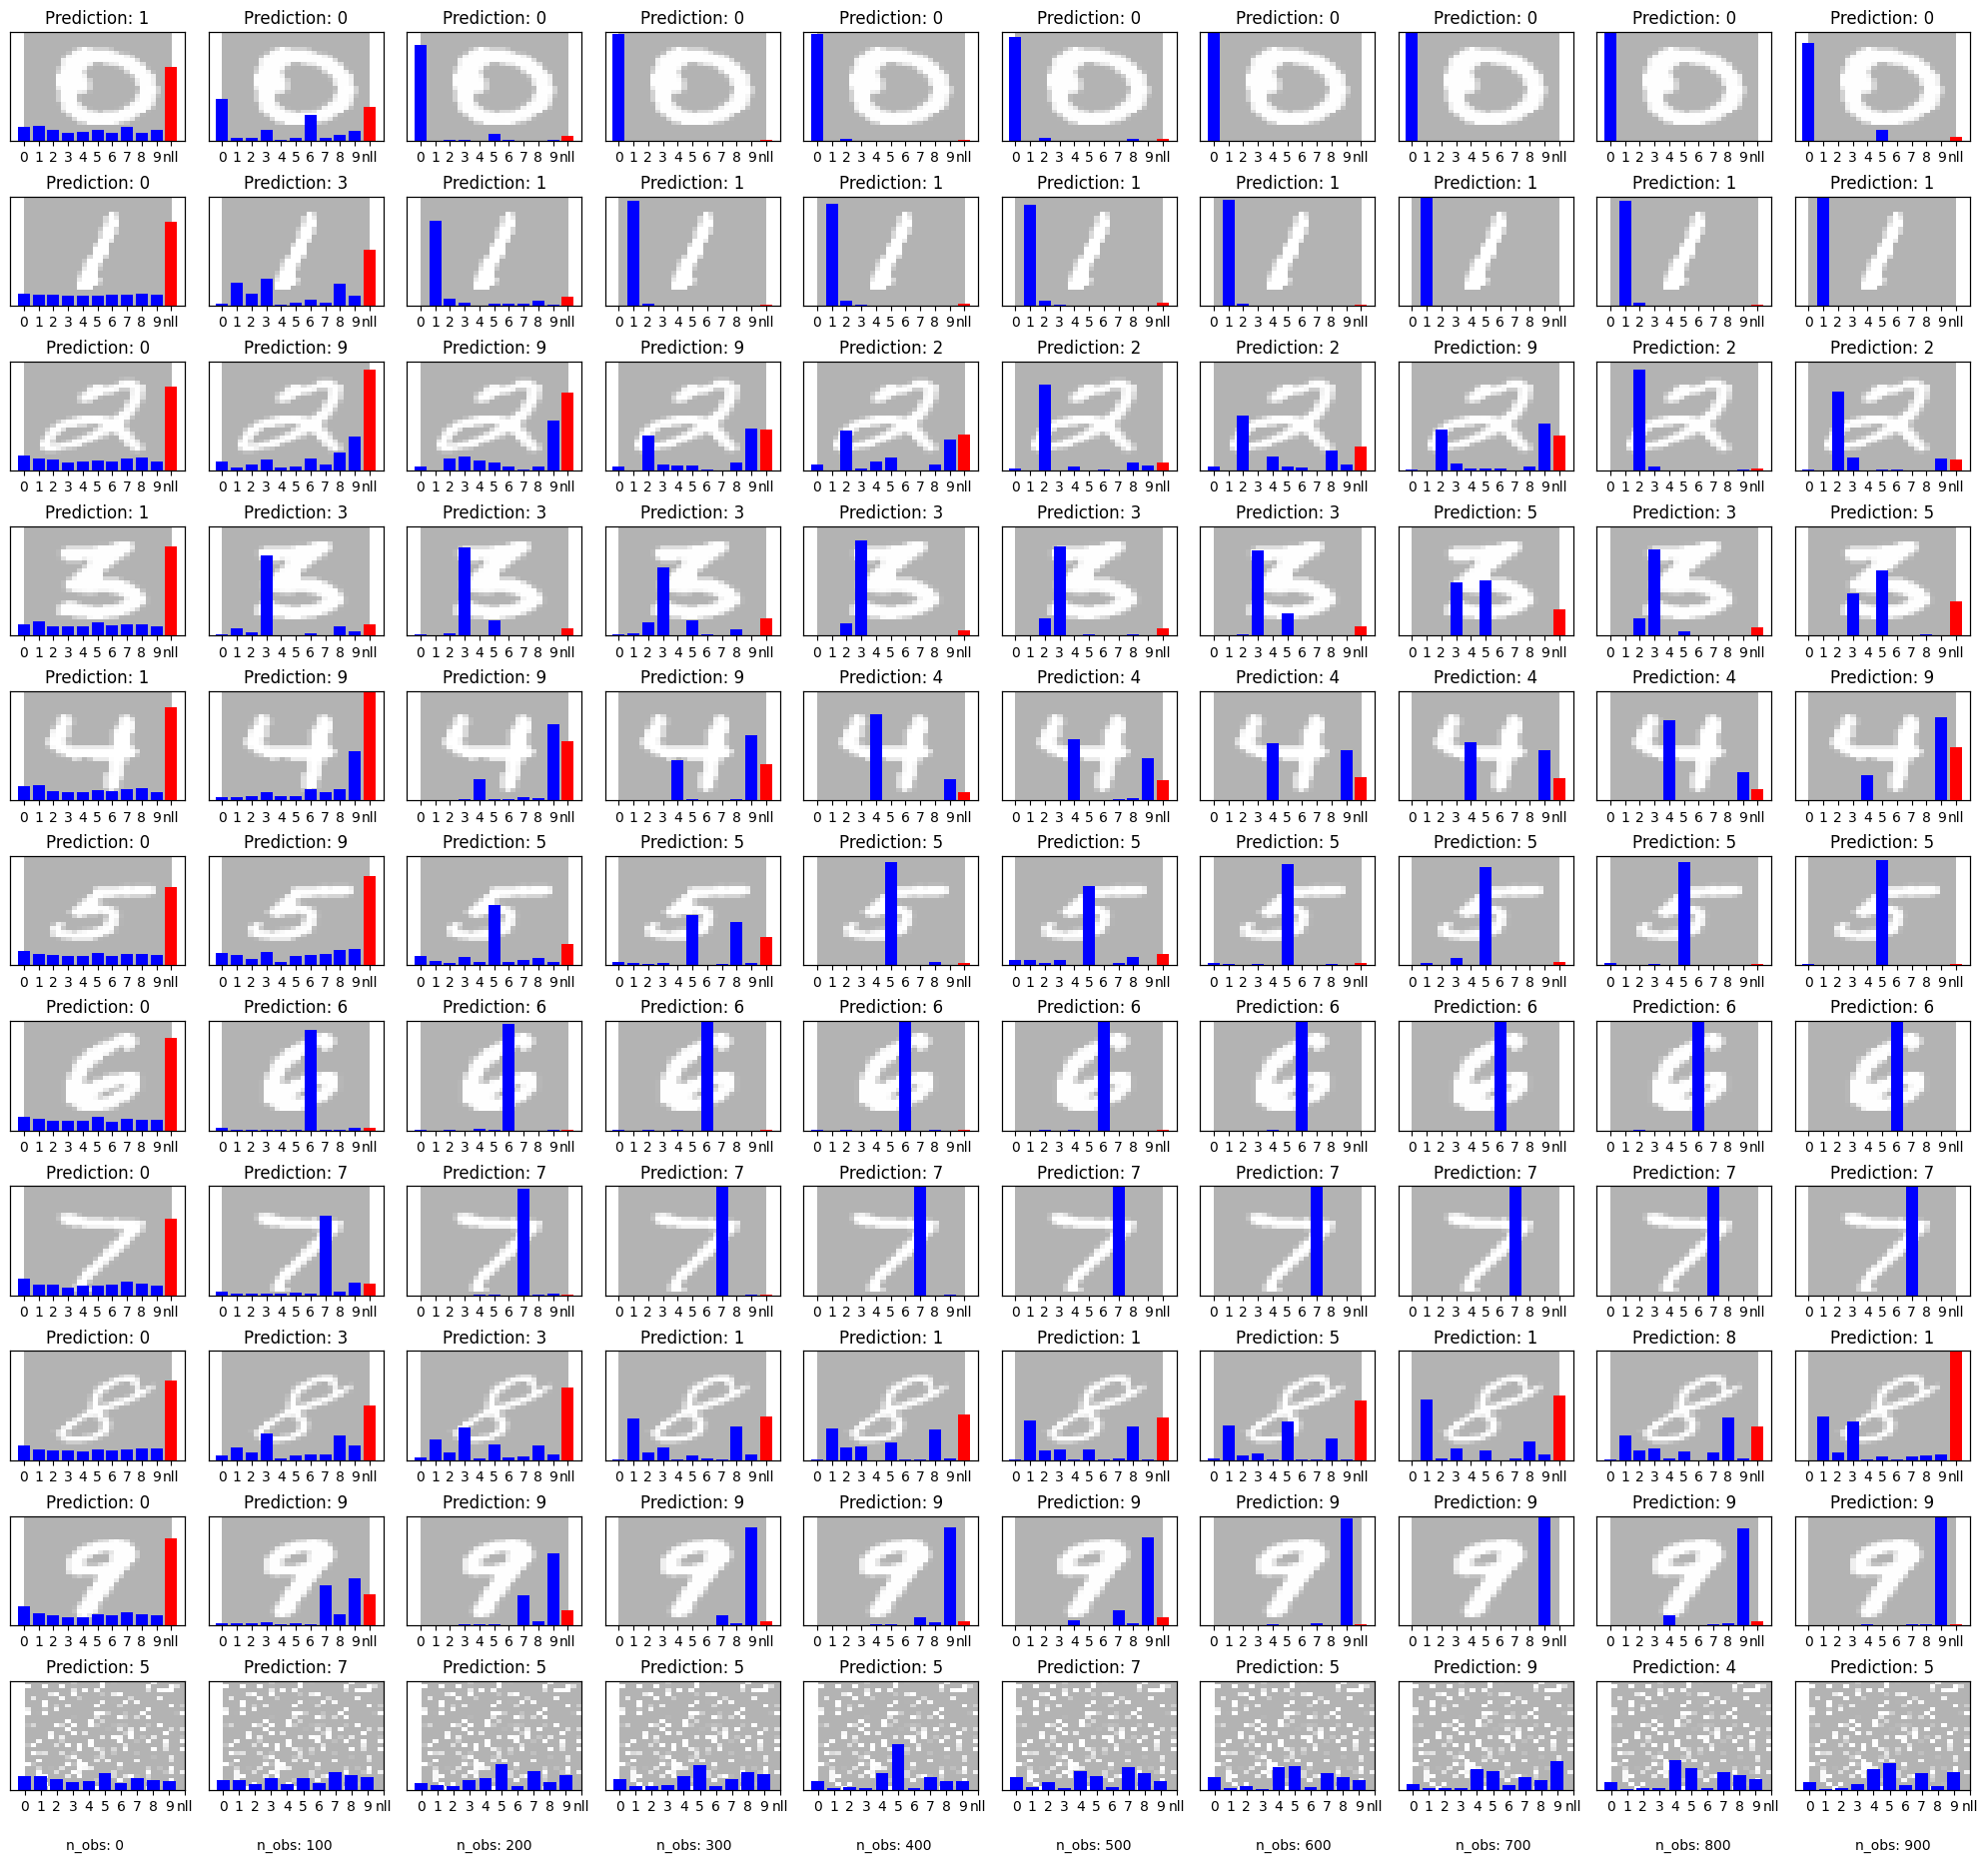

In [69]:
# Plot probed predictions
frames = jnp.arange(0, 1_000, 100)
n_test_images = 11
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 20))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        if j < 10:
            curr_img = test_images[j]
        else:
            curr_img = ood_img
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = model_dict_mlp['apply_fn'](est_mlp[frame], curr_img.reshape(1, 28, 28, 1))
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, jnp.array(j))
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Prediction: {preds.argmax()}")
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


## 1.2 Zero-LeCun-Normal Probe

In [70]:
# Initialize model
mlp_zll_init_fn = lambda key: benchmark.init_model(type='mlp', features=(100, 100, 10), 
                                                   key=key, rescale=False, zero_ll=True)
model_dict_mlp_zll = mlp_zll_init_fn(0)


In [71]:
# Tune hyperparameters
X_train, y_train = dataset['train']
train = (X_train[:500], y_train[:500])

kwargs = {
    'memory_size': 5,
    'inflation': "hybrid",
    'lofi_method': "diagonal",
}

pbounds={
    'log_init_cov': (-10.0, 0.0),
    'log_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-90, -90),
    'log_alpha': (-40, -40),
}
agent_type = 'lofi'
init_points, n_iter = 10, 15

ll_callback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_ll)

optimizer = hpt.create_optimizer(
    mlp_zll_init_fn, pbounds, train, dataset['val'], callback=ll_callback, 
    method=agent_type, verbose=2, callback_at_end=False, n_seeds=3, **kwargs
)

optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
)
best_hparams = hpt.get_best_params(optimizer, method=agent_type)
print(f"Best target: {optimizer.max['target']}")

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.157    | -40.0     | -90.0     | -90.0     | -4.551    |
| 2         | -1.757    | -40.0     | -90.0     | -90.0     | -1.082    |
| 3         | -2.205    | -40.0     | -90.0     | -90.0     | -4.711    |
| 4         | -2.302    | -40.0     | -90.0     | -90.0     | -9.129    |
| 5         | -1.505    | -40.0     | -90.0     | -90.0     | -1.3      |
| 6         | -1.306    | -40.0     | -90.0     | -90.0     | -2.195    |
| 7         | -2.377    | -40.0     | -90.0     | -90.0     | -0.5533   |
| 8         | -1.305    | -40.0     | -90.0     | -90.0     | -2.258    |
| 9         | -1.762    | -40.0     | -90.0     | -90.0     | -3.824    |
| 10        | -1.414    | -40.0     | -90.0     | -90.0     | -3.182    |
| 11        | -2.298    | -40.0     | -90.0     | -90.0     | -7.005    |
| 12        | -1.309    | -40.0     | 

In [72]:
# Initialize an instance of the model with best hparams
estimator_mlp_zll, init_mean_mlp_zll, init_cov_mlp_zll = hpt.build_estimator(
    model_dict_mlp_zll,
    best_hparams,
    method=agent_type,
    **kwargs,
)

In [73]:
# Train
def map_callback(bel, *args, **kwargs):
    return bel

_, outcomes = estimator_mlp_zll.scan(init_mean_mlp_zll, init_cov_mlp_zll, 
                                     X_train[:1_000], y_train[:1_000], map_callback)
est_mlp_zll = outcomes.mean
flat_params = model_dict_mlp_zll["flat_params"]
est_mlp_zll = jnp.concatenate([flat_params.reshape(1,-1), est_mlp_zll])

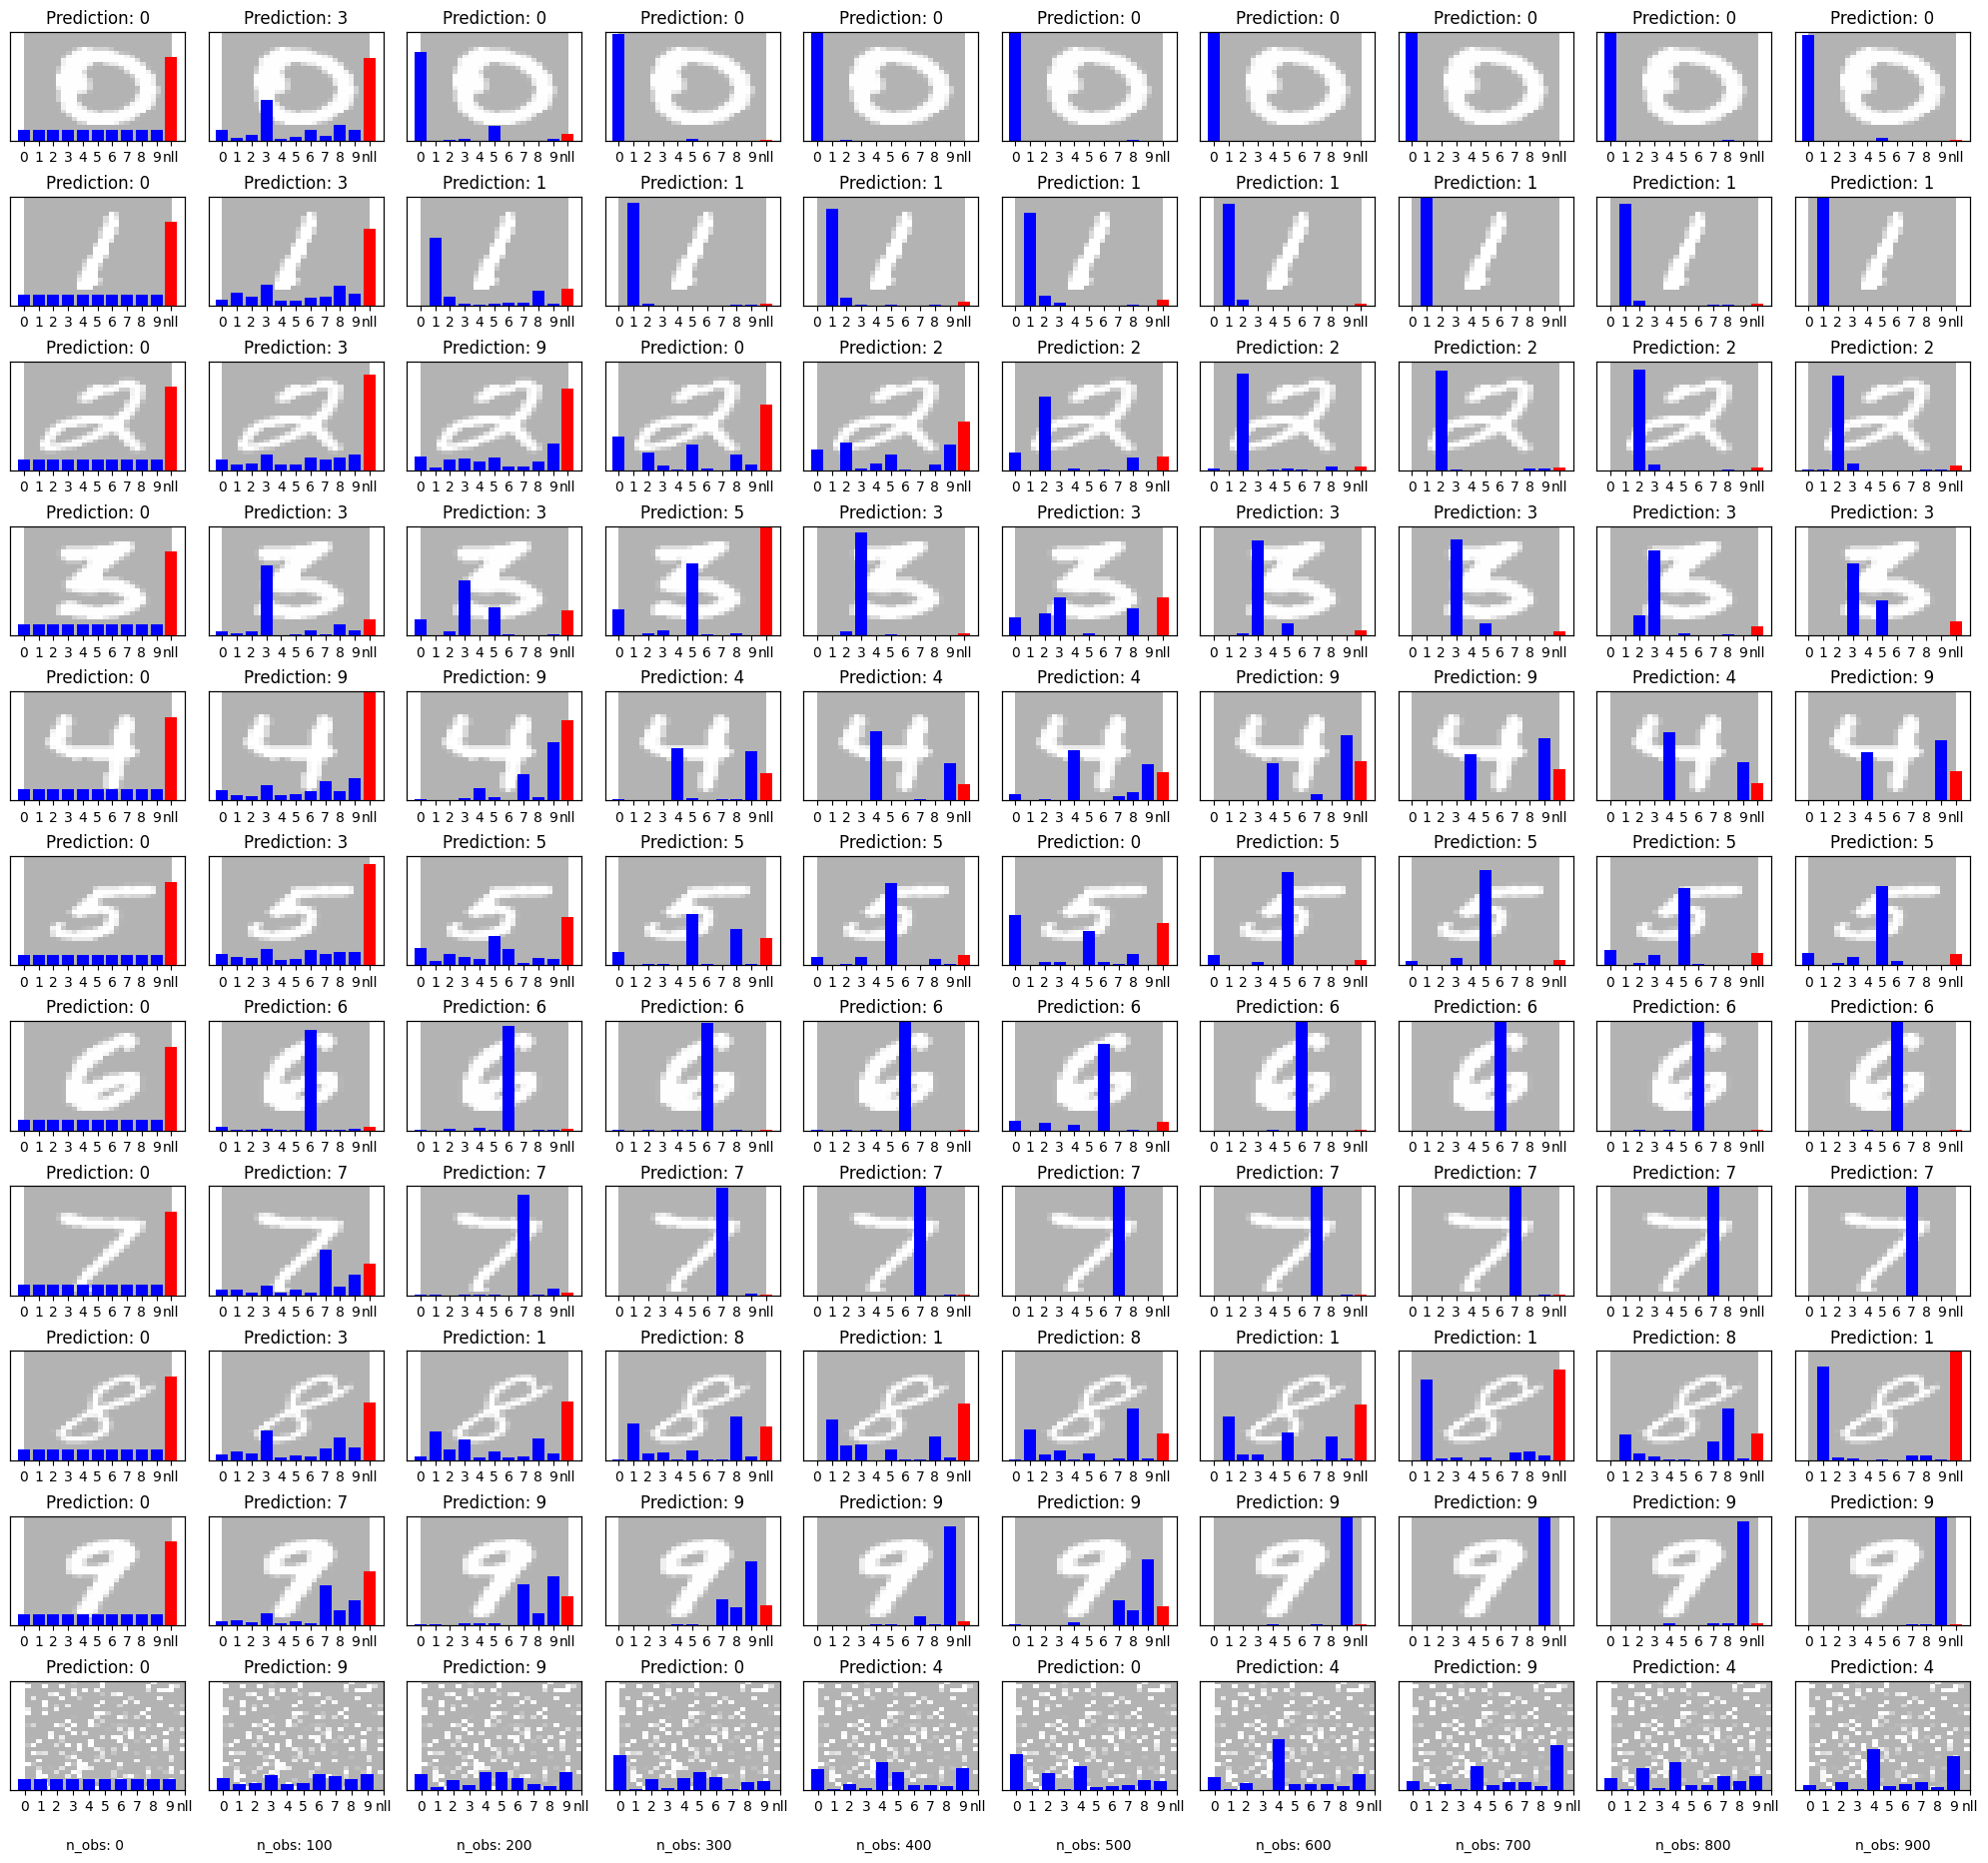

In [74]:
# Plot probed predictions
frames = jnp.arange(0, 1_000, 100)
n_test_images = 11
fig, axs = plt.subplots(n_test_images, len(frames), figsize=(20, 20))

for i, frame in enumerate(frames):
    for j in range(n_test_images):
        if j < 10:
            curr_img = test_images[j]
        else:
            curr_img = ood_img
        ax = axs[j][i]
        ax.imshow(curr_img, cmap='gray', extent=[0, 10, 0, 1], aspect='auto', alpha=0.3)
        ax.set_xticks(list(range(10)) + [10])
        ax.set_xticklabels(list(map(str, range(10))) + ['nll'])
        ax.set_ylim(0, 1)
        ax.set_yticks([])

        ax2 = ax.twinx()
        ax2.set_ylim(0, 3.0)
        ax2.set_yticks([])

        logits = model_dict_mlp_zll['apply_fn'](est_mlp_zll[frame], curr_img.reshape(1, 28, 28, 1))
        preds = jax.nn.softmax(logits).ravel()
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, jnp.array(j))
        
        ax.bar(range(10), preds, color='blue')
        ax2.bar(10, nll, color='red')
        
        ax.set_title(f"Prediction: {preds.argmax()}")
    
    fig.text(0.5 / len(frames) + i / len(frames), 0.04, f'n_obs: {frame}', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.07)  # Make room for the column titles
plt.show()


## 1.3 Convergence Comparison

In [75]:
# Lecun Normal
eval_callback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_nll_and_miscl)
result_mlp, *_ = jax.block_until_ready(
    benchmark.mnist_eval_agent(
        mlp_init_fn, init_cov_mlp, dataset['train'], dataset['test'], model_dict_mlp['apply_fn'], 
        callback=eval_callback, agent=estimator_mlp, n_iter=100
    )
)

nll_mlp, miscl_mlp = (
    {
        "mean": result_mlp[key].mean(axis=0), 
        "std": result_mlp[key].std(axis=0),
    }
    for key in ('nll', 'miscl')
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [76]:
# Zero-Lecun Normal
eval_callback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_nll_and_miscl)
result_mlp_zll, *_ = jax.block_until_ready(
    benchmark.mnist_eval_agent(
        mlp_zll_init_fn, init_cov_mlp_zll, dataset['train'], dataset['test'], 
        model_dict_mlp['apply_fn'], callback=eval_callback, agent=estimator_mlp_zll, 
        n_iter=100
    )
)

nll_mlp_zll, miscl_mlp_zll = (
    {
        "mean": result_mlp_zll[key].mean(axis=0), 
        "std": result_mlp_zll[key].std(axis=0),
    }
    for key in ('nll', 'miscl')
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [77]:
results_mlp_nll = {
    "Lecun-Normal": nll_mlp,
    "Zero-Lecun-Normal": nll_mlp_zll,
}

results_mlp_miscl = {
    "Lecun-Normal": miscl_mlp,
    "Zero-Lecun-Normal": miscl_mlp_zll,
}

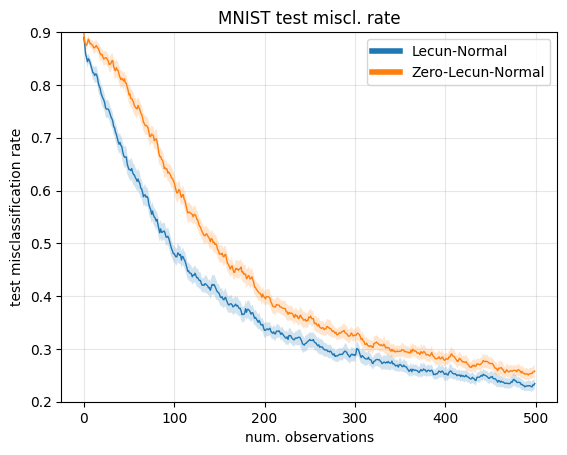

In [82]:
fig, ax = plt.subplots()
for key, val in results_mlp_miscl.items():
    mean, std = val['mean'], val['std']
    ax.plot(mean, label=key, linewidth=1.0)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test misclassification rate')
ax.set_ylim(0.2, 0.9)
ax.grid(alpha=0.3)
ax.set_title('MNIST test miscl. rate')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

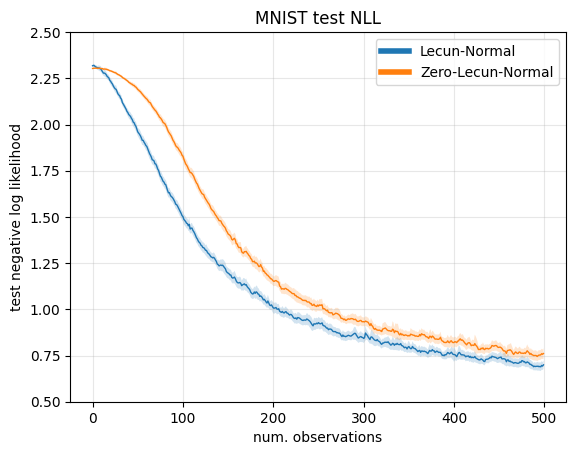

In [83]:
fig, ax = plt.subplots()
for key, val in results_mlp_nll.items():
    mean, std = val['mean'], val['std']
    ax.plot(mean, label=key, linewidth=1.0)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test negative log likelihood')
ax.set_ylim(0.5, 2.5)
ax.grid(alpha=0.3)
ax.set_title('MNIST test NLL')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)